We demonstrate how the test cases for glasses perturbation are generated and optimised. This generation is based on a group of tuning face recognition systems in white-box setting.

# 1. Sample Generation
The input to the generation agorithm (mPGD) is a set of face pairs (face_1, face_2)

In [1]:
import numpy as np
from PIL import Image

sample_face_pairs = [(np.array(Image.open(f"samples/image_{k}_A.jpg").resize((112, 112))),
                     np.array(Image.open(f"samples/image_{k}_B.jpg").resize((112, 112)))) for k in range(20)]

print("How many pairs are in the input?", len(sample_face_pairs))
print("-> Change 20 to a higher number for full generation.")

How many pairs are in the input? 20


In [2]:
import sys
sys.path.append('whitebox_adversarial')
from objective import WhiteboxWithOneSystem, WhiteboxWithMultipleSystems
from image2perturbed import WhiteboxGlassesPerturbation

In [3]:
perturb = WhiteboxGlassesPerturbation()
my_systems = ['FaceNet', 'r50', 'EfficientNet', 'ReXNet', 'AttentionNet', 'RepVGG', 'GhostNet', 'TF-NAS', 'LightCNN']


import random
random.seed(100000)

my_system = random.choice(my_systems)

In [4]:
from tqdm.notebook import tqdm, trange

box = WhiteboxWithMultipleSystems(my_system)
print(my_system)

generated_samples = []

for k, (i1, i2) in enumerate(sample_face_pairs):
    print("sample", k)

    i1 = np.expand_dims(i1, 0) 
    i2 = np.expand_dims(i2, 0) 

    sim = box.cosine_similarity(i1, i2)
    y_pred = np.sign(box.y_preds[0] - 0.5)

    i1_ = np.array(i1, copy=True)

    min_bce = 1

    for i in trange(1000):
        g_1, _ = box.get_grads(i1_, i2)
        i1_ = perturb.perturb_single_image(i1, i1_, y_pred * g_1)
        sim_test = box.cosine_similarity(i1_, i2)

        if sim_test * y_pred < min_bce:
            min_bce = sim_test * y_pred
            generated_samples.append((i1, i1_.astype(np.uint8), i2))

r50
sample 0


  0%|          | 0/1000 [00:00<?, ?it/s]

sample 1


  0%|          | 0/1000 [00:00<?, ?it/s]

sample 2


  0%|          | 0/1000 [00:00<?, ?it/s]

sample 3


  0%|          | 0/1000 [00:00<?, ?it/s]

sample 4


  0%|          | 0/1000 [00:00<?, ?it/s]

sample 5


  0%|          | 0/1000 [00:00<?, ?it/s]

sample 6


  0%|          | 0/1000 [00:00<?, ?it/s]

sample 7


  0%|          | 0/1000 [00:00<?, ?it/s]

sample 8


  0%|          | 0/1000 [00:00<?, ?it/s]

sample 9


  0%|          | 0/1000 [00:00<?, ?it/s]

sample 10


  0%|          | 0/1000 [00:00<?, ?it/s]

sample 11


  0%|          | 0/1000 [00:00<?, ?it/s]

sample 12


  0%|          | 0/1000 [00:00<?, ?it/s]

sample 13


  0%|          | 0/1000 [00:00<?, ?it/s]

sample 14


  0%|          | 0/1000 [00:00<?, ?it/s]

sample 15


  0%|          | 0/1000 [00:00<?, ?it/s]

sample 16


  0%|          | 0/1000 [00:00<?, ?it/s]

sample 17


  0%|          | 0/1000 [00:00<?, ?it/s]

sample 18


  0%|          | 0/1000 [00:00<?, ?it/s]

sample 19


  0%|          | 0/1000 [00:00<?, ?it/s]

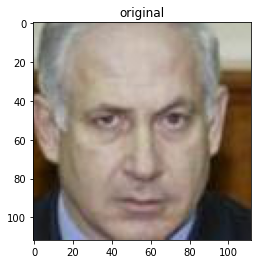

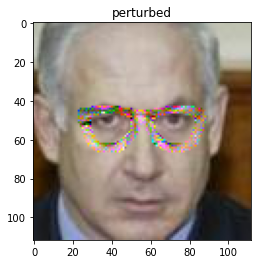

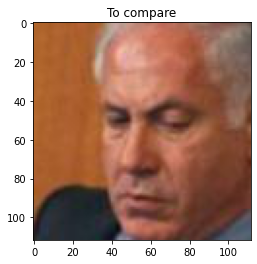

In [5]:
import matplotlib.pyplot as plt
plt.imshow(generated_samples[-1][0].squeeze(0))
plt.title('original')
plt.show()
plt.imshow(generated_samples[-1][1].squeeze(0))
plt.title('perturbed')
plt.show()
plt.imshow(generated_samples[-1][2].squeeze(0))
plt.title('To compare')
plt.show()

pre-compute the prediction of each face recognition system on each sample, so we don't need to repeat it in the optimisation loop later. Save the dict below as "pre-computed-alters.pkl"

In [6]:
all_alters = {}

for my_system in my_systems:
    print(my_system)
    
    box = WhiteboxWithMultipleSystems(my_system)

    altered = []
    for sample in tqdm(generated_samples):
        _ = box.cosine_similarity(sample[0], sample[2])
        y_pred = box.y_preds[0]
        _ = box.cosine_similarity(sample[1], sample[2])
        y_pred_ = box.y_preds[0]
        altered.append(y_pred != y_pred_)      


    all_alters[my_system] = altered

import pandas as pd
df = pd.DataFrame(all_alters)
df

FaceNet


  0%|          | 0/8255 [00:00<?, ?it/s]

r50


  0%|          | 0/8255 [00:00<?, ?it/s]

EfficientNet
backbone param:
{'width': 1.0, 'depth': 1.0, 'image_size': 112, 'drop_ratio': 0.2, 'out_h': 7, 'out_w': 7, 'feat_dim': 512}
backbone param:
{'width': 1.0, 'depth': 1.0, 'image_size': 112, 'drop_ratio': 0.2, 'out_h': 7, 'out_w': 7, 'feat_dim': 512}


  0%|          | 0/8255 [00:00<?, ?it/s]

ReXNet
backbone param:
{'input_ch': 16, 'final_ch': 180, 'width_mult': 1.0, 'depth_mult': 1.0, 'use_se': 0, 'se_ratio': 12, 'out_h': 7, 'out_w': 7, 'feat_dim': 512, 'dropout_ratio': 0.2}
backbone param:
{'input_ch': 16, 'final_ch': 180, 'width_mult': 1.0, 'depth_mult': 1.0, 'use_se': 0, 'se_ratio': 12, 'out_h': 7, 'out_w': 7, 'feat_dim': 512, 'dropout_ratio': 0.2}


  0%|          | 0/8255 [00:00<?, ?it/s]

AttentionNet
backbone param:
{'stage1_modules': 1, 'stage2_modules': 2, 'stage3_modules': 3, 'feat_dim': 512, 'out_h': 7, 'out_w': 7}
backbone param:
{'stage1_modules': 1, 'stage2_modules': 2, 'stage3_modules': 3, 'feat_dim': 512, 'out_h': 7, 'out_w': 7}


  0%|          | 0/8255 [00:00<?, ?it/s]

RepVGG
backbone param:
{'blocks1': 2, 'blocks2': 4, 'blocks3': 14, 'blocks4': 1, 'width1': 0.75, 'width2': 0.75, 'width3': 0.75, 'width4': 2.5, 'out_h': 7, 'out_w': 7, 'feat_dim': 512}
backbone param:
{'blocks1': 2, 'blocks2': 4, 'blocks3': 14, 'blocks4': 1, 'width1': 0.75, 'width2': 0.75, 'width3': 0.75, 'width4': 2.5, 'out_h': 7, 'out_w': 7, 'feat_dim': 512}


  0%|          | 0/8255 [00:00<?, ?it/s]

GhostNet
backbone param:
{'width': 1.0, 'drop_ratio': 0.2, 'out_h': 7, 'out_w': 7, 'feat_dim': 512}
backbone param:
{'width': 1.0, 'drop_ratio': 0.2, 'out_h': 7, 'out_w': 7, 'feat_dim': 512}


  0%|          | 0/8255 [00:00<?, ?it/s]

TF-NAS
backbone param:
{'feat_dim': 512, 'drop_ratio': 0.2, 'out_h': 7, 'out_w': 7}
backbone param:
{'feat_dim': 512, 'drop_ratio': 0.2, 'out_h': 7, 'out_w': 7}


  0%|          | 0/8255 [00:00<?, ?it/s]

LightCNN
backbone param:
{'depth': 29, 'out_h': 7, 'out_w': 7, 'feat_dim': 512, 'dropout_ratio': 0.2}
backbone param:
{'depth': 29, 'out_h': 7, 'out_w': 7, 'feat_dim': 512, 'dropout_ratio': 0.2}


  0%|          | 0/8255 [00:00<?, ?it/s]

,FaceNet,r50,EfficientNet,ReXNet,AttentionNet,RepVGG,GhostNet,TF-NAS,LightCNN
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
8250,True,True,False,False,False,False,False,False,False
8251,False,True,False,False,False,False,False,False,False
8252,True,True,False,False,False,False,False,False,False
8253,False,True,False,False,False,False,False,False,False
